# MINST classifier based on the examples within:

*   Fundamentals of Deep Learning, 2nd Edition
*   Programming PyTorch for Deep Learning


In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
#from PIL import Image
#from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# The core objects and functions

1. set up the base [classifier](https://learning.oreilly.com/library/view/fundamentals-of-deep/9781492082170/ch05.html#:-:text=class%20BaseClassifier(nn.Module)%3A)

In [3]:
class BaseClassifier(nn.Module):
  def __init__(self, in_dim, feature_dim, out_dim):
    super(BaseClassifier, self).__init__()
    # two layer classifier
    self.classifier = nn.Sequential(
      nn.Linear(in_dim, feature_dim, bias=True),
      nn.ReLU(),
      nn.Linear(feature_dim, out_dim, bias=True)
    )

  def forward(self, x):
    return self.classifier(x)

2. create the classify function with the model.  Classify takes a tensor for the image data, and output the label: { 0, 1, ..9 }

In [4]:
def getClassify(model):
  # put model in inference (prediciton) mode
  model.eval()
  def _classify(data) :
    data = data.flatten(start_dim=1)
    # run the classifier
    out = model(data)
    # derive the prediction
    _, preds = out.max(dim=1)
    return (out, preds)
  return _classify

3. define the [training loop](https://learning.oreilly.com/library/view/fundamentals-of-deep/9781492082170/ch05.html#:-:text=def%20train(classifier,epochs%2C%0A%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0%C2%A0loss_fn%3Dloss_fn)%3A), inputs the base classifier, an optimization function, loss function and the number of epocks

In [5]:
def train(classifier, loader, optimizer, epochs, loss_fn):
  classifier.train()
  total_training_loss = []
  for epoch in range(epochs):
    epoch_loss = 0.0

    num_batches = len(loader)
    # for each "tensor of images" in the training set minibatch
    for minibatch in loader:
      data, target = minibatch
      data = data.flatten(start_dim=1)

      # run the classifier
      out = classifier(data)
      # calculate the loss from the prediciton and the true "label"
      minibatch_loss = loss_fn(out, target)
      # calculate the partial derivatives of the weights, and
      #   have the optimizer update the weights
      minibatch_loss.backward()
      optimizer.step()
      # [COMMON MISTAKE] zero out the gradients otherwise they will increment
      optimizer.zero_grad()

      # keep track of the running loss for this minibatch
      epoch_loss += minibatch_loss.item()

    # append running loss from minibatch tot he
    total_training_loss.append(epoch_loss/num_batches)
    print("Epoch: {} train loss: {}".format(epoch+1, epoch_loss/num_batches))
  return total_training_loss


4. define the test loop

In [6]:
def test(classify, loader, loss_fn):
  accuracy = 0.0

  with torch.no_grad():
      computed_loss = 0.0
      # for each minibatch in the loader (TODO, does the tester have minibatches?)
      for data, target in loader:
          data = data.flatten(start_dim=1)

          # run the classifier
          out, preds = classify(data)

          # Get loss and accuracy
          computed_loss += loss_fn(out, target)
          # accuracy increases when the prediciton
          #  is the same as the attached lable
          accuracy += torch.sum(preds==target)

      # calculate the length
      length = len(loader)*64

      print("Test loss: {}, test accuracy: {}".format(
          computed_loss.item()/length,
          accuracy*100.0/length))

      return accuracy * 100 / length

 5. define a function that plots the loss from the training exercise, for no real reason other than to look at it

In [7]:
def plot_loss(title, loss):
  l = len(loss)
  plt.plot([i for i in range(1,l+1)], loss)
  plt.xlabel("Epoch")
  plt.ylabel("Training Loss")
  plt.title(title)
  plt.show()

# Train the classifier

1. load MNIST training and test as pytorch **DataSet**, and construct the pytorch **DataLoader**

In [8]:
# for random numbers
generator = torch.Generator().manual_seed(42)

# create datasets
train_dataset = MNIST(".", train=True, download=True, transform=ToTensor())

# MINST doesn't separate testing from validation so use the
#  random_split function to allocate 80% to test and 20% to validation
temp_dataset  = MNIST(".", train=False, download=True, transform=ToTensor())
test_dataset, validation_dataset = random_split(temp_dataset, [.8, .2], generator)

train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 140409150.99it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12363308.21it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57116476.14it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5940295.84it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



2. Train classifier, and capture the loss after every epoch (this bit takes 5-10 minutes)

In [23]:
# define the classifier
learning_rate = 1e-3
in_dim, feature_dim, out_dim = 784, 256, 10
#in_dim, feature_dim, out_dim = 784, 10, 10
classifier = BaseClassifier(in_dim, feature_dim, out_dim)

# instantiate stochasit gradient descent optimizer
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

#train the classifier, with train_dataset
num_epochs = 30 #40
training_loss = train(classifier=classifier, loader=train_loader, optimizer=optimizer, epochs=num_epochs, loss_fn=nn.CrossEntropyLoss())

# save the trained model
torch.save(classifier.state_dict(), 'mnist.pt')



Epoch: 1 train loss: 2.212143858104372
Epoch: 2 train loss: 1.9809187730746483
Epoch: 3 train loss: 1.68478576041488
Epoch: 4 train loss: 1.3795010527568077
Epoch: 5 train loss: 1.130164593648809
Epoch: 6 train loss: 0.9516653852549188
Epoch: 7 train loss: 0.8277315775087393
Epoch: 8 train loss: 0.7397947373674877
Epoch: 9 train loss: 0.6749279873012733
Epoch: 10 train loss: 0.6254087780266683
Epoch: 11 train loss: 0.5863993720713455
Epoch: 12 train loss: 0.5549107039216231
Epoch: 13 train loss: 0.5290097204734013
Epoch: 14 train loss: 0.5074076200090746
Epoch: 15 train loss: 0.48896180010680707
Epoch: 16 train loss: 0.47319716319981925
Epoch: 17 train loss: 0.45935816130340734
Epoch: 18 train loss: 0.44722082812204034
Epoch: 19 train loss: 0.43675307039894273
Epoch: 20 train loss: 0.42710321279032143
Epoch: 21 train loss: 0.4187374030793908
Epoch: 22 train loss: 0.41085793411553795
Epoch: 23 train loss: 0.4039383700915745
Epoch: 24 train loss: 0.39757432340622456
Epoch: 25 train loss:

3. plot the loss (just to visualize it)

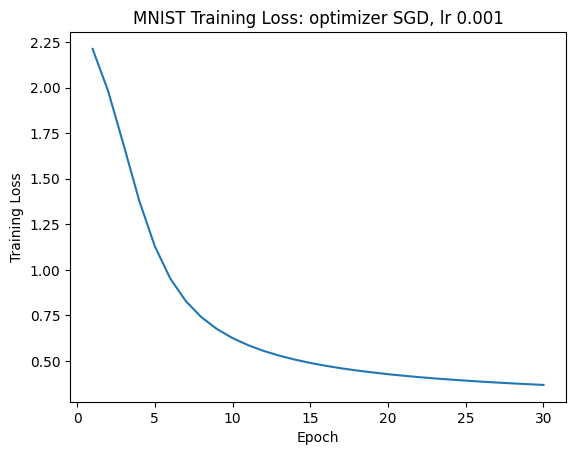

In [24]:
title = "MNIST Training Loss: optimizer {}, lr {}".format("SGD", learning_rate)
plot_loss(title, training_loss)

4. test the classifier and show the accuracy

In [25]:
classify = getClassify(classifier)
accuracy = test(classify, test_loader, nn.CrossEntropyLoss())
print("total accuracy:", accuracy.item())

Test loss: 0.005364204883575439, test accuracy: 90.6875
total accuracy: 90.6875


5. pick some images from the validation dataset and a) classify them, and then plot that image and the correct label

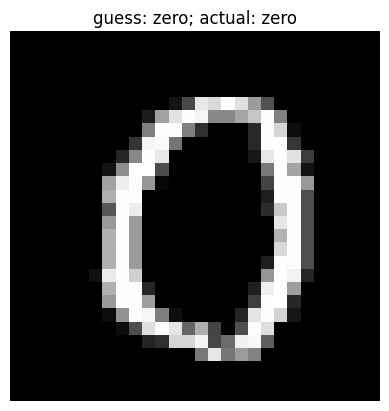

In [13]:
labels_map = {
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
    0: "zero"
}


length = len(validation_dataset)

#todo: I couldn't figure out how to get this to plt in a grid of say 12
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
for i in range(1,2):
  sample_idx = torch.randint(length, size=(1,)).item()
  img, label = validation_dataset[sample_idx]

  # classify return the loss and predictions
  weights, predicted_label = classify(img)
  # in this case we only passed in one image and
  #   only want one prediction so extract it
  predicted_label = predicted_label.item()

  # plot image with predicted label and true label
  title = "guess: " + labels_map[predicted_label] + "; actual: " + labels_map[label]
  plt.title(title)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

In [32]:
loss

tensor([[ 1.6804, -5.0462,  0.9508, -2.1133,  0.8790,  2.3084,  7.2444, -5.7561,
         -0.2180, -0.8438]], grad_fn=<AddmmBackward0>)